# BeatMapCurveShapes

The code here is meant to support the associated dataset, that contains Beat Saber map, score, and player information, originally sourced from [BeatLeader](https://beatleader.com/), enriched with a 14-parameter parameterization of absolutely monotonic PP curve shapes for maps, that explain the scores well. The dataset is meant to be used by anybody attempting to produce map difficulty estimation algorithms from the map objects directly, as a supervised dataset of ground truth to target and/or evaluate with respect to.

These parameterizations were produced with the code included in https://github.com/Undeceiver/BetaSaber, which by definition means every PP curve is absolutely monotonic, and aimed to find the PP curves for maps that were absolutely monotonic and best explained the scores.

The functions and variables present here help extract and unpack the data, calculate PP values, and visualize results, for the dataset itself, and for potential comparative parameterizations / curves that wish to be compared to them.

If you are planning to train your own difficulty estimation algorithm, you will need the map files themselves. These are way too much to include in the repository, but you can download them from Beat Saver using [BeatLeader's playlist](https://beatleader.com/playlist/ranked)

Scroll to the end to see example usage.

## Imports

In [69]:
import datetime
from IPython.display import display, Markdown, Latex
import io
import json
import math
import matplotlib.pyplot as plt
import numpy
import random
from urllib.request import urlretrieve
import zipfile

## Load and unpack the dataset

- `data_zip_file` - Name of zip.
- `full_data` - Dictionary result of reading the JSON of the dataset.
- `player_data` - List of players, each of which is a dictionary with different data about the player.
- `map_data` - List of maps, each of which is a dictionary with different data about the map.
- `players_by_id` - Dictionary of players, indexed by their id.
- `maps_by_id` - Dictionary of maps, indexed by their id.
- `score_data` - List of scores, each of which is a dictionary with different data about that specific score.
- `map_params` - Dictionary indexed by map id, with the list of 14 parameters that define the PP curve of that map as values.
- `scores_by_player_id` - Dictionary indexed by player id first, and map id next, storing the score data for that player on that map.
- `scores_by_map_id` - Dictionary indexed by map id first, and player id next, storing the score data on that map for that player.
- `score_data_by_map_id` - Dictionary containing the list of raw accuracy values (between 0 and 1) for each map, indexed by id.

Please note that scores are not filtered here. If you are looking to use scores to train an algorithm, take into account that the `pp_curve` function below does not consider modifiers, but there are scores with modifiers in the dataset. You'll need to decide how exactly to deal with modifiers in your algorithm if you are using scores for training.

In [3]:
global data_zip_file
data_zip_file = "dump.zip"

In [11]:
global full_data

with zipfile.ZipFile(data_zip_file, 'r') as z:
    inner_name = z.namelist()[0]
    
    with z.open(inner_name) as f:        
        with io.TextIOWrapper(f, encoding='utf-8') as text_file:
            full_data = json.load(text_file)

In [57]:
global player_data
global map_data
global score_data

player_data = full_data["Players"]
map_data = full_data["Maps"]
score_data = full_data["Scores"]

In [54]:
global players_by_id
global maps_by_id

players_by_id = {player["Id"] : player for player in player_data}
maps_by_id = {bmap["Id"] : bmap for bmap in map_data}

In [55]:
global map_params

map_params = {this_map["Id"]: this_map["Params"] for this_map in map_data}

In [58]:
global scores_by_player_id
global scores_by_map_id
global score_data_by_map_id

scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    

    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   

    
    this_score_data = score_data_by_map_id.get(map_id,[])

    this_score_data.append(score["Accuracy"])
    
    score_data_by_map_id[map_id] = this_score_data

for score in score_data:
    add_score(score)

for map_id in score_data_by_map_id:
    this_score_data = score_data_by_map_id[map_id]
    this_score_data.sort()
    score_data_by_map_id[map_id] = numpy.array(this_score_data)

## Download the map zips

- `beat_saver_cdn_url` - Base URL to download map zips.
- `map_folder` - Name of the local folder where maps are downloaded to.
- `download_map` - Function that receives the ID of a leaderboard and downloads the map zip into the appropriate folder

In [63]:
global beat_saver_cdn_url
global map_folder

beat_saver_cdn_url = "http://r2cdn.beatsaver.com/"
map_folder = "maps"

In [64]:
def download_map(map_id):
    map_hash = maps_by_id[map_id]["Hash"]
    url = f"{beat_saver_cdn_url}{map_hash}.zip"    
    filename = f"{map_folder}/{map_id}.zip"

    urlretrieve(url,filename)

In [ ]:
i = random.randint(0,3500)

this_map = map_data[i]

print(f"Hash: {this_map["Hash"]}")

download_map(this_map["Id"])

## Calculate PP values

- `n_proportional_exponentials` - Number of exponentials added. This is half the number of parameters.
- `min_proportional_exponential_exponent` - Initial exponent from which the final exponents are built.

Note that changing the above parameters **will lead to incorrect curves**, as the parameterization in the dataset is defined with respect to this. They are made available for reference, but they are to be considered fixed values.

- `pp_curve` - Function taking an accuracy value `x` (between 0 and 1) and the list of map parameters, and returns the PP value of said score. Modifiers are not considered here.
- `generate_pp_curve` - Function that generates an interpolated curve of the map, which can then be used to call `pp_curve_interp`, generating values equivalent to `pp_curve`, but much more efficient when generating many values.
- `pretty_print_params` - Function that returns a string with the formula for the curve determined by the given parameters.

In [45]:
# The number of parameters will be twice this.
global n_proportional_exponentials
n_proportional_exponentials = 7

global min_proportional_exponential_exponent
min_proportional_exponential_exponent = 1

In [47]:
def pp_curve(x, params):
    total = 0
    cur_exponent = min_proportional_exponential_exponent

    # SUM (a * e^((previous*multiplier)x) - 1)/(e^(previous*multiplier) - 1)
    for i in range(n_proportional_exponentials):
        cur_exponent *= params[2*i]
        total += params[2*i+1]*numpy.divide(numpy.exp(cur_exponent*x) - 1,numpy.exp(cur_exponent) - 1)

    return total

In [85]:
def generate_pp_curve(params):
    xx = numpy.arange(0,1,0.01)
    
    yy = pp_curve(xx,params)
    
    return (xx,yy)

def pp_curve_interp(x, xx, yy):
    result = numpy.interp(x,xx,yy)    
    return result

In [48]:
def pretty_print_params(params):
    result = ""
    cur_exponent = min_proportional_exponential_exponent

    for i in range(n_proportional_exponentials):
        cur_exponent *= params[2*i]
        result += f" + {params[2*i+1]:.2f}uexp({cur_exponent:.2f})"

    return result

## Visualizations

- `key_points` - Key score percentage points (between 0 and 1) to show in the graphs.
- `x_ticks` - Ticks to display on the X axis of PP graphs.
- `show_map_pp_by_map_id` - Call to show the curve as stored in the dataset for the given map id.
- `show_map_pp` - Call with specific map data, scores, skill values, and map parameters, to show the graph of the resulting curve.
- `global_stats` - Global statistics of all maps.
- `global sorted_lists` - Global lists of maps sorted by different statistics.
- `calculate_statistics` - Function that generates and fills statistics in `global_stats` and `global_sorted_lists`. This is called automatically if this module is imported. Call it again with new map parameters to check statistics on alternative map parameterizations.
- `show_all_global_stats` - Show charts with summarized statistics.

If you prefer to view the data of this dataset in a display more similar to BeatLeader, check out https://portable.undeceiver.beatleader.pro (all PP values there are multiplied by 600 with respect to here) but with the functions here you can actually visualize your own parameters and compare them to the ones in the dataset.

In [77]:
global key_points
global x_ticks

key_points = [0.75,0.9,0.97,1]
x_ticks = [0, 0.25, 0.5, 0.75, 1]

In [78]:
# Takes the data directly from the dataset
def show_map_pp_by_map_id(map_id, linear_scale=True, log_scale=False, **kwargs):        
       
    scores = score_data_by_map_id[map_id]
    scores_with_players = scores_by_map_id[map_id]

    sort_func = lambda player_id: scores_with_players[player_id]["Accuracy"]
    sorted_player_ids = list(scores_with_players.keys())
    sorted_player_ids.sort(key=sort_func)
    skills = [players_by_id[player_id]["Skill"] for player_id in sorted_player_ids]

    this_map_data = maps_by_id[map_id]
    
    show_map_pp(this_map_data,scores, skills, map_params[map_id], linear_scale = linear_scale, log_scale = log_scale, **kwargs)

# Here you can set your own parameters
def show_map_pp(this_map_data, scores, skills, params, linear_scale = True, log_scale = False):        
    n_scores = len(scores)
    
    xx = numpy.linspace(0,1,n_scores)        
        
    pp_curve_values = pp_curve(xx,params)

    max_pp = pp_curve(1,params) 
    
    n_key_points = len(key_points)
    
    pp_at_key_points = [pp_curve(key_point,params) for key_point in key_points]    
    labels_at_key_points = [f"{key_points[i]*100:.2f}% = {pp_at_key_points[i]:.2f} PP" for i in range(n_key_points)]

    max_score = this_map_data["gold_standard"]
    pp_at_max_score = pp_curve(max_score,params)
    pp_at_key_points.append(pp_at_max_score)   
    
    labels_at_key_points.append(f"{max_score*100:.2f}% (max. realistic score) = {pp_at_max_score:.2f} PP")

    if linear_scale:
        plt.scatter(scores, skills, marker='.', label="Scores")            
        plt.plot(xx,pp_curve_values,"c",label="PP curve")
                
        for i in range(n_key_points+1):
            color = (i/n_key_points,1 - i/n_key_points, 0, 0.2)
            plt.hlines(pp_at_key_points[i],0,1,colors=color,linestyles="dashed")

        x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]
        
        ax = plt.gca()
        ax.set_xlim([0,1])
        ax.set_ylim([0, max_pp*1.1])
        ax.set_yticks(pp_at_key_points,labels=labels_at_key_points)
        ax.set_xticks(x_ticks,labels=x_labels)
    
        map_id = this_map_data["Id"]
        map_name = this_map_data["Name"]
        map_mapper = this_map_data["Mapper"]
        map_mode = this_map_data["ModeName"]
        map_difficulty = this_map_data["DifficultyName"]
        
        plt.title(f"PP curve for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})\n{pretty_print_params(params)}")
        plt.xlabel("Score percentage")
        plt.ylabel("PP / Player skill")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
        plt.show()

    if log_scale:
        plt.yscale("log",base=2)
        plt.scatter(scores, skills, marker='.', label="Scores")            
        plt.plot(xx,pp_curve_values,"c",label="PP curve")
                
        for i in range(n_key_points+1):
            color = (i/n_key_points,1 - i/n_key_points, 0, 0.2)
            plt.hlines(pp_at_key_points[i],0,1,colors=color,linestyles="dashed")

        x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]       
        
        ax = plt.gca()
        ax.set_yticks(pp_at_key_points,labels=labels_at_key_points)
        ax.set_xticks(x_ticks,labels=x_labels)
        ax.set_xlim([0,1])
        ax.set_ylim([pp_at_key_points[0]/1.1, pp_at_max_score*1.1])        
    
        map_id = this_map_data["Id"]
        map_name = this_map_data["Name"]
        map_mapper = this_map_data["Mapper"]
        map_mode = this_map_data["ModeName"]
        map_difficulty = this_map_data["DifficultyName"]
        
        plt.title(f"PP curve for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) (logscale)\n{pretty_print_params(params)}")
        plt.xlabel("Score percentage")
        plt.ylabel("PP / Player skill")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
        plt.show()

The following has very long code but it's not that complex. It's just a bunch of statistics calculations to display statistics graphs.

In [86]:
def calculate_statistics(players_by_id, maps_by_id, scores_by_player_id, scores_by_map_id, result_map_params, global_stats, sorted_lists):
    print(f"Adding columns to players")
    add_columns_players(players_by_id, maps_by_id, scores_by_player_id, result_map_params)
    print(f"Adding columns to scores per map")
    add_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params)
    print(f"Adding columns to scores per player")
    add_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params)
    print(f"Calculating statistics per map")
    calculate_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params)
    print(f"Calculating statistics per player")
    calculate_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params)
    print(f"Calculating global statistics")
    calculate_global_statistics(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats)
    print(f"Add relative columns to scores per map")
    add_relative_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats)
    print(f"Add relative columns to scores per player")
    add_relative_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, global_stats)
    print(f"Calculating relative statistics per map")
    calculate_relative_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats)
    print(f"Calculating relative statistics per player")
    calculate_relative_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, global_stats)
    print(f"Calculating global player statistics")
    calculate_global_player_statistics(players_by_id, maps_by_id, result_map_params, global_stats)
    print(f"Calculating global map statistics")
    calculate_global_map_statistics(players_by_id, maps_by_id, result_map_params, global_stats)
    print(f"Creating sorted score lists for top/bottom values")
    create_sorted_score_lists(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats, sorted_lists)
    print(f"Creating sorted map lists for top/bottom values")
    create_sorted_map_lists(players_by_id, maps_by_id, result_map_params, global_stats, sorted_lists)
    print(f"Creating sorted player lists for top/bottom values")
    create_sorted_player_lists(players_by_id, maps_by_id, result_map_params, global_stats, sorted_lists)
    
    print("Finished.")

# Adding columns to players
def add_columns_players(players_by_id, maps_by_id, scores_by_player_id, result_map_params):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
         
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")

        # Number of scores
        n_scores = len(scores)
        player_data["NScores"] = n_scores

# Adding columns to scores
def add_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params):            
    n = 0
    for map_id,scores in scores_by_map_id.items():
        #map_data = maps_by_id[map_id]
        map_params = result_map_params[map_id]

        (xx,yy) = generate_pp_curve(map_params)
        
        for player_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")
                
            accuracy = score_data["Accuracy"]            
            
            # PP
            pp = pp_curve_interp(accuracy,xx,yy)
            score_data["PP"] = pp           

def add_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params):            
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        
        for map_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")                
                        
            # Number of scores of the player
            n_scores = player_data["NScores"]
            score_data["PlayerNScores"] = n_scores

# Calculating direct statistics
def calculate_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params):
    n = 0
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")
            
        # PP
        pps = numpy.array([score_data["PP"] for score_data in scores.values()])
        # Max
        max_pp = numpy.max(pps)
        map_data["MaxPP"] = max_pp
        # 90%
        ninety_pp = numpy.quantile(pps,0.9)
        map_data["NinetyPP"] = ninety_pp
        # Min
        min_pp = numpy.min(pps)
        map_data["MinPP"] = min_pp
        # Mean
        mean_pp = numpy.mean(pps)
        map_data["AvgPP"] = mean_pp
        # Median
        median_pp = numpy.median(pps)
        map_data["MedianPP"] = median_pp   

        # PP for players with at least 40 scores        
        pps40 = numpy.array([score_data["PP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # Max
        max_pp40 = numpy.max(pps40)
        map_data["MaxPP40"] = max_pp40
        # 90%
        ninety_pp40 = numpy.quantile(pps40,0.9)
        map_data["NinetyPP40"] = ninety_pp40
        # Min
        min_pp40 = numpy.min(pps40)
        map_data["MinPP40"] = min_pp40
        # Mean
        mean_pp40 = numpy.mean(pps40)
        map_data["AvgPP40"] = mean_pp40
        # Median
        median_pp40 = numpy.median(pps40)
        map_data["MedianPP40"] = median_pp40   

def calculate_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")
            
        # PP
        pps = numpy.array([score_data["PP"] for score_data in scores.values()])
        # Max
        max_pp = numpy.max(pps)
        player_data["MaxPP"] = max_pp
        # 90%
        ninety_pp = numpy.quantile(pps,0.9)
        player_data["NinetyPP"] = ninety_pp
        # Min
        min_pp = numpy.min(pps)
        player_data["MinPP"] = min_pp
        # Mean
        mean_pp = numpy.mean(pps)
        player_data["AvgPP"] = mean_pp
        # Median
        median_pp = numpy.median(pps)
        player_data["MedianPP"] = median_pp

# Modifies global_stats dictionary
def calculate_global_statistics(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats):
    n = 0
    # Per score
    arrays_pp = []        
    arrays_pp40 = []
    for map_id,scores in scores_by_map_id.items():    
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")
        
        arrays_pp.append(numpy.array([score_data["PP"] for score_data in scores.values()]))
        arrays_pp40.append(numpy.array([score_data["PP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40]))
    
    # PP
    pps = numpy.concatenate(arrays_pp)
    # Max
    max_pp = numpy.max(pps)
    global_stats["MaxPP"] = max_pp
    # 90%
    ninety_pp = numpy.quantile(pps,0.9)
    global_stats["NinetyPP"] = ninety_pp
    # Min
    min_pp = numpy.min(pps)
    global_stats["MinPP"] = min_pp
    # Mean
    mean_pp = numpy.mean(pps)
    global_stats["AvgPP"] = mean_pp
    # Median
    median_pp = numpy.median(pps)
    global_stats["MedianPP"] = median_pp 

    # PP for players with at least 40 scores
    pps40 = numpy.concatenate(arrays_pp40)
    # Max
    max_pp40 = numpy.max(pps40)
    global_stats["MaxPP40"] = max_pp40
    # 90%
    ninety_pp40 = numpy.quantile(pps40,0.9)
    global_stats["NinetyPP40"] = ninety_pp40
    # Min
    min_pp40 = numpy.min(pps40)
    global_stats["MinPP40"] = min_pp40
    # Mean
    mean_pp40 = numpy.mean(pps40)
    global_stats["AvgPP40"] = mean_pp40
    # Median
    median_pp40 = numpy.median(pps40)
    global_stats["MedianPP40"] = median_pp40   
            
# Adding relative columns to scores
def add_relative_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats):            
    n = 0
    top_global_pp = global_stats["MaxPP"]    
    top_global_pp40 = global_stats["MaxPP40"]
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        top_pp = map_data["MaxPP"]
        top_pp40 = map_data["MaxPP40"]

        for player_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")
                
            pp = score_data["PP"]

            # PP/Top PP
            pp_div_top_global_pp = pp/top_global_pp
            score_data["PPDivTopPP"] = pp_div_top_global_pp

            # PP/Top PP 40
            pp_div_top_global_pp40 = pp/top_global_pp40
            score_data["PPDivTopPP40"] = pp_div_top_global_pp40
            
            # PP/Top Map PP            
            pp_div_top_pp = pp/top_pp            
            score_data["PPDivTopMapPP"] = pp_div_top_pp          

            # PP/Top Map PP 40            
            pp_div_top_pp40 = pp/top_pp40
            score_data["PPDivTopMapPP40"] = pp_div_top_pp40

def add_relative_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, global_stats):            
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]

        top_pp = player_data["MaxPP"]
        
        for map_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")                

            pp = score_data["PP"]            
            
            # PP/Top Player PP            
            pp_div_top_pp = pp/top_pp            
            score_data["PPDivTopPlayerPP"] = pp_div_top_pp

# Calculating relative statistics
def calculate_relative_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats):
    n = 0
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")

        # PP/Top PP
        pps_div_top_pp = numpy.array([score_data["PPDivTopPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp = numpy.max(pps_div_top_pp)
        map_data["MaxPPDivTopPP"] = max_pp_div_top_pp
        # 90%
        ninety_pp_div_top_pp = numpy.quantile(pps_div_top_pp,0.9)
        map_data["NinetyPPDivTopPP"] = ninety_pp_div_top_pp
        # Mean
        mean_pp_div_top_pp = numpy.mean(pps_div_top_pp)
        map_data["AvgPPDivTopPP"] = mean_pp_div_top_pp
        # Median
        median_pp_div_top_pp = numpy.median(pps_div_top_pp)
        map_data["MedianPPDivTopPP"] = median_pp_div_top_pp

        # PP/Top PP for players with at least 40 scores
        pps_div_top_pp40 = numpy.array([score_data["PPDivTopPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp40 = numpy.max(pps_div_top_pp40)
        map_data["MaxPPDivTopPP40"] = max_pp_div_top_pp40
        # 90%
        ninety_pp_div_top_pp40 = numpy.quantile(pps_div_top_pp40,0.9)
        map_data["NinetyPPDivTopPP40"] = ninety_pp_div_top_pp40
        # Mean
        mean_pp_div_top_pp40 = numpy.mean(pps_div_top_pp40)
        map_data["AvgPPDivTopPP40"] = mean_pp_div_top_pp40
        # Median
        median_pp_div_top_pp40 = numpy.median(pps_div_top_pp40)
        map_data["MedianPPDivTopPP40"] = median_pp_div_top_pp40
        
        # PP/Top Map PP
        pps_div_top_map_pp = numpy.array([score_data["PPDivTopMapPP"] for score_data in scores.values()])
        # 90%
        ninety_pp_div_top_map_pp = numpy.quantile(pps_div_top_map_pp,0.9)
        map_data["NinetyPPDivTopMapPP"] = ninety_pp_div_top_map_pp
        # Mean
        mean_pp_div_top_map_pp = numpy.mean(pps_div_top_map_pp)
        map_data["AvgPPDivTopMapPP"] = mean_pp_div_top_map_pp
        # Median
        median_pp_div_top_map_pp = numpy.median(pps_div_top_map_pp)
        map_data["MedianPPDivTopMapPP"] = median_pp_div_top_map_pp   

        # PP/Top Map PP for players with at least 40 scores      
        pps_div_top_map_pp40 = numpy.array([score_data["PPDivTopMapPP40"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # 90%
        ninety_pp_div_top_map_pp40 = numpy.quantile(pps_div_top_map_pp40,0.9)
        map_data["NinetyPPDivTopMapPP40"] = ninety_pp_div_top_map_pp40
        # Mean
        mean_pp_div_top_map_pp40 = numpy.mean(pps_div_top_map_pp40)
        map_data["AvgPPDivTopMapPP40"] = mean_pp_div_top_map_pp40
        # Median
        median_pp_div_top_map_pp40 = numpy.median(pps_div_top_map_pp40)
        map_data["MedianPPDivTopMapPP40"] = median_pp_div_top_map_pp40

        # PP/Top Player PP
        pps_div_top_player_pp = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_player_pp = numpy.max(pps_div_top_player_pp)
        map_data["MaxPPDivTopPlayerPP"] = max_pp_div_top_player_pp
        # 90%
        ninety_pp_div_top_player_pp = numpy.quantile(pps_div_top_player_pp,0.9)
        map_data["NinetyPPDivTopPlayerPP"] = ninety_pp_div_top_player_pp
        # Mean
        mean_pp_div_top_player_pp = numpy.mean(pps_div_top_player_pp)
        map_data["AvgPPDivTopPlayerPP"] = mean_pp_div_top_player_pp
        # Median
        median_pp_div_top_player_pp = numpy.median(pps_div_top_player_pp)
        map_data["MedianPPDivTopPlayerPP"] = median_pp_div_top_player_pp

        # PP/Top Player PP for players with at least 40 scores
        pps_div_top_player_pp40 = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # Max
        max_pp_div_top_player_pp40 = numpy.max(pps_div_top_player_pp40)
        map_data["MaxPPDivTopPlayerPP40"] = max_pp_div_top_player_pp40
        # 90%
        ninety_pp_div_top_player_pp40 = numpy.quantile(pps_div_top_player_pp40,0.9)
        map_data["NinetyPPDivTopPlayerPP40"] = ninety_pp_div_top_player_pp40
        # Mean
        mean_pp_div_top_player_pp40 = numpy.mean(pps_div_top_player_pp40)
        map_data["AvgPPDivTopPlayerPP40"] = mean_pp_div_top_player_pp40
        # Median
        median_pp_div_top_player_pp40 = numpy.median(pps_div_top_player_pp40)
        map_data["MedianPPDivTopPlayerPP40"] = median_pp_div_top_player_pp40

def calculate_relative_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, global_stats):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")

        # PP/Top PP
        pps_div_top_pp = numpy.array([score_data["PPDivTopPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp = numpy.max(pps_div_top_pp)
        player_data["MaxPPDivTopPP"] = max_pp_div_top_pp
        # 90%
        ninety_pp_div_top_pp = numpy.quantile(pps_div_top_pp,0.9)
        player_data["NinetyPPDivTopPP"] = ninety_pp_div_top_pp
        # Mean
        mean_pp_div_top_pp = numpy.mean(pps_div_top_pp)
        player_data["AvgPPDivTopPP"] = mean_pp_div_top_pp
        # Median
        median_pp_div_top_pp = numpy.median(pps_div_top_pp)
        player_data["MedianPPDivTopPP"] = median_pp_div_top_pp

        # PP/Top PP for players with at least 40 scores
        pps_div_top_pp40 = numpy.array([score_data["PPDivTopPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp40 = numpy.max(pps_div_top_pp40)
        player_data["MaxPPDivTopPP40"] = max_pp_div_top_pp40
        # 90%
        ninety_pp_div_top_pp40 = numpy.quantile(pps_div_top_pp40,0.9)
        player_data["NinetyPPDivTopPP40"] = ninety_pp_div_top_pp40
        # Mean
        mean_pp_div_top_pp40 = numpy.mean(pps_div_top_pp40)
        player_data["AvgPPDivTopPP40"] = mean_pp_div_top_pp40
        # Median
        median_pp_div_top_pp40 = numpy.median(pps_div_top_pp40)
        player_data["MedianPPDivTopPP40"] = median_pp_div_top_pp40
        
        # PP/Top Map PP
        pps_div_top_map_pp = numpy.array([score_data["PPDivTopMapPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_map_pp = numpy.max(pps_div_top_map_pp)
        player_data["MaxPPDivTopMapPP"] = max_pp_div_top_map_pp
        # 90%
        ninety_pp_div_top_map_pp = numpy.quantile(pps_div_top_map_pp,0.9)
        player_data["NinetyPPDivTopMapPP"] = ninety_pp_div_top_map_pp
        # Mean
        mean_pp_div_top_map_pp = numpy.mean(pps_div_top_map_pp)
        player_data["AvgPPDivTopMapPP"] = mean_pp_div_top_map_pp
        # Median
        median_pp_div_top_map_pp = numpy.median(pps_div_top_map_pp)
        player_data["MedianPPDivTopMapPP"] = median_pp_div_top_map_pp   

        # PP/Top Map PP for players with at least 40 scores      
        pps_div_top_map_pp40 = numpy.array([score_data["PPDivTopMapPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_map_pp40 = numpy.max(pps_div_top_map_pp40)
        player_data["MaxPPDivTopMapPP40"] = max_pp_div_top_map_pp40
        # 90%
        ninety_pp_div_top_map_pp40 = numpy.quantile(pps_div_top_map_pp40,0.9)
        player_data["NinetyPPDivTopMapPP40"] = ninety_pp_div_top_map_pp40
        # Mean
        mean_pp_div_top_map_pp40 = numpy.mean(pps_div_top_map_pp40)
        player_data["AvgPPDivTopMapPP40"] = mean_pp_div_top_map_pp40
        # Median
        median_pp_div_top_map_pp40 = numpy.median(pps_div_top_map_pp40)
        player_data["MedianPPDivTopMapPP40"] = median_pp_div_top_map_pp40

        # PP/Top Player PP
        pps_div_top_player_pp = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values()])
        # 90%
        ninety_pp_div_top_player_pp = numpy.quantile(pps_div_top_player_pp,0.9)
        player_data["NinetyPPDivTopPlayerPP"] = ninety_pp_div_top_player_pp
        # Mean
        mean_pp_div_top_player_pp = numpy.mean(pps_div_top_player_pp)
        player_data["AvgPPDivTopPlayerPP"] = mean_pp_div_top_player_pp
        # Median
        median_pp_div_top_player_pp = numpy.median(pps_div_top_player_pp)
        player_data["MedianPPDivTopPlayerPP"] = median_pp_div_top_player_pp                

def calculate_global_player_statistics(players_by_id, maps_by_id, result_map_params, global_stats):
    # Ninety PP of the player as compared to the top player PP - Ninety, and Median values.
    ninety_pps_div_top_player_pp = numpy.array([player_data["NinetyPPDivTopPlayerPP"] for player_data in players_by_id.values() if player_data.get("NScores",0) >= 40])
    # 90%
    ninety_ninety_pp_div_top_player_pp = numpy.quantile(ninety_pps_div_top_player_pp,0.9)
    global_stats["NinetyPlayerNinetyPPDivTopPlayerPP"] = ninety_ninety_pp_div_top_player_pp
    # Median
    median_ninety_pp_div_top_player_pp = numpy.median(ninety_pps_div_top_player_pp)
    global_stats["MedianPlayerNinetyPPDivTopPlayerPP"] = median_ninety_pp_div_top_player_pp

    # Median PP of the player as compared to the top player PP - Ninety, and Median values.
    median_pps_div_top_player_pp = numpy.array([player_data["MedianPPDivTopPlayerPP"] for player_data in players_by_id.values() if player_data.get("NScores",0) >= 40])
    # 90%
    ninety_median_pp_div_top_player_pp = numpy.quantile(median_pps_div_top_player_pp,0.9)
    global_stats["NinetyPlayerMedianPPDivTopPlayerPP"] = ninety_median_pp_div_top_player_pp
    # Median
    median_median_pp_div_top_player_pp = numpy.median(median_pps_div_top_player_pp)
    global_stats["MedianPlayerMedianPPDivTopPlayerPP"] = median_median_pp_div_top_player_pp

def calculate_global_map_statistics(players_by_id, maps_by_id, result_map_params, global_stats):
    # Max PP40 of the map - Ninety and Median values.
    max_pps40 = numpy.array([map_data["MaxPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_max_pp40 = numpy.quantile(max_pps40,0.9)
    global_stats["NinetyMapMaxPP40"] = ninety_max_pp40
    # Median
    median_max_pp40 = numpy.median(max_pps40)
    global_stats["MedianMapMaxPP40"] = median_max_pp40

    # Ninety PP40 of the map - Max, Ninety, and Median values.
    ninety_pps40 = numpy.array([map_data["NinetyPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp40 = numpy.quantile(ninety_pps40,0.9)
    global_stats["NinetyMapNinetyPP40"] = ninety_ninety_pp40
    # Median
    median_ninety_pp40 = numpy.median(ninety_pps40)
    global_stats["MedianMapNinetyPP40"] = median_ninety_pp40

    # Median PP40 of the map - Max, Ninety, and Median values.
    median_pps40 = numpy.array([map_data["MedianPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp40 = numpy.quantile(median_pps40,0.9)
    global_stats["NinetyMapMedianPP40"] = ninety_median_pp40
    # Median
    median_median_pp40 = numpy.median(median_pps40)
    global_stats["MedianMapMedianPP40"] = median_median_pp40

    # Ninety PP40 of the map compared to the top map PP - Ninety and Median values.
    ninety_pps_div_top_map_pp40 = numpy.array([map_data["NinetyPPDivTopMapPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp_div_top_map_pp40 = numpy.quantile(ninety_pps_div_top_map_pp40,0.9)
    global_stats["NinetyMapNinetyPPDivTopMapPP40"] = ninety_ninety_pp_div_top_map_pp40
    # Median
    median_ninety_pp_div_top_map_pp40 = numpy.median(ninety_pps_div_top_map_pp40)
    global_stats["MedianMapNinetyPPDivTopMapPP40"] = median_ninety_pp_div_top_map_pp40

    # Median PP40 of the map compared to the top map PP - Ninety and Median values.
    median_pps_div_top_map_pp40 = numpy.array([map_data["MedianPPDivTopMapPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp_div_top_map_pp40 = numpy.quantile(median_pps_div_top_map_pp40,0.9)
    global_stats["NinetyMapMedianPPDivTopMapPP40"] = ninety_median_pp_div_top_map_pp40
    # Median
    median_median_pp_div_top_map_pp40 = numpy.median(median_pps_div_top_map_pp40)
    global_stats["MedianMapMedianPPDivTopMapPP40"] = median_median_pp_div_top_map_pp40

    # Ninety PP40 of the map compared to the top player's PP - Ninety and Median values.
    ninety_pps_div_top_player_pp40 = numpy.array([map_data["NinetyPPDivTopPlayerPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp_div_top_player_pp40 = numpy.quantile(ninety_pps_div_top_player_pp40,0.9)
    global_stats["NinetyMapNinetyPPDivTopPlayerPP40"] = ninety_ninety_pp_div_top_player_pp40
    # Median
    median_ninety_pp_div_top_player_pp40 = numpy.median(ninety_pps_div_top_player_pp40)
    global_stats["MedianMapNinetyPPDivTopPlayerPP40"] = median_ninety_pp_div_top_player_pp40

    # Median PP40 of the map compared to the top player's PP - Ninety and Median values.
    median_pps_div_top_player_pp40 = numpy.array([map_data["MedianPPDivTopPlayerPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp_div_top_player_pp40 = numpy.quantile(median_pps_div_top_player_pp40,0.9)
    global_stats["NinetyMapMedianPPDivTopPlayerPP40"] = ninety_median_pp_div_top_player_pp40
    # Median
    median_median_pp_div_top_player_pp40 = numpy.median(median_pps_div_top_player_pp40)
    global_stats["MedianMapMedianPPDivTopPlayerPP40"] = median_median_pp_div_top_player_pp40

def create_sorted_score_lists(players_by_id, maps_by_id, scores_by_map_id, result_map_params, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    scores = [score_data for map_scores in scores_by_player_id.values() for score_data in map_scores.values()]

    # PP
    scores.sort(key=sort_key_dict("PP"), reverse=True)
    sorted_lists["scores_by_pp"] = scores.copy()

def create_sorted_map_lists(players_by_id, maps_by_id, result_map_params, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    maps = list(maps_by_id.values())
    
    # MaxPP40
    maps.sort(key=sort_key_dict("MaxPP40"), reverse=True)
    sorted_lists["maps_by_max_pp40"] = maps.copy()

    # NinetyPP40
    maps.sort(key=sort_key_dict("NinetyPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp40"] = maps.copy()

    # MedianPP40
    maps.sort(key=sort_key_dict("MedianPP40"), reverse=True)
    sorted_lists["maps_by_median_pp40"] = maps.copy()

    # NinetyPPDivTopMapPP40
    maps.sort(key=sort_key_dict("NinetyPPDivTopMapPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp_div_top_map_pp40"] = maps.copy()

    # MedianPPDivTopPP40
    maps.sort(key=sort_key_dict("MedianPPDivTopMapPP40"), reverse=True)
    sorted_lists["maps_by_median_pp_div_top_map_pp40"] = maps.copy()

    # NinetyPPDivTopPlayerPP40
    maps.sort(key=sort_key_dict("NinetyPPDivTopPlayerPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp_div_top_player_pp40"] = maps.copy()

    # MedianPPDivTopPlayerPP40
    maps.sort(key=sort_key_dict("MedianPPDivTopPlayerPP40"), reverse=True)
    sorted_lists["maps_by_median_pp_div_top_player_pp40"] = maps.copy()

def create_sorted_player_lists(players_by_id, maps_by_id, result_map_params, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    players = [player for player in players_by_id.values() if player.get("NScores",0) >= 40]

    # MaxPP
    players.sort(key=sort_key_dict("MaxPP"), reverse=True)
    sorted_lists["players_by_max_pp"] = players.copy()

    # NinetyPP
    players.sort(key=sort_key_dict("NinetyPP"), reverse=True)
    sorted_lists["players_by_ninety_pp"] = players.copy()

    # MedianPP
    players.sort(key=sort_key_dict("MedianPP"), reverse=True)
    sorted_lists["players_by_median_pp"] = players.copy()

    # AveragePP
    players.sort(key=sort_key_dict("AvgPP"), reverse=True)
    sorted_lists["players_by_avg_pp"] = players.copy()

    # NinetyPPDivTopPlayerPP
    players.sort(key=sort_key_dict("NinetyPPDivTopPlayerPP"), reverse=True)
    sorted_lists["players_by_ninety_pp_div_top_player_pp"] = players.copy()

    # MedianPPDivTopPlayerPP
    players.sort(key=sort_key_dict("MedianPPDivTopPlayerPP"), reverse=True)
    sorted_lists["players_by_median_pp_div_top_player_pp"] = players.copy()

In [87]:
global global_stats
global sorted_lists

global_stats = {}
sorted_lists = {}

calculate_statistics(players_by_id, maps_by_id, scores_by_player_id, scores_by_map_id, map_params, global_stats, sorted_lists)

Adding columns to players
5000 players processed
10000 players processed
15000 players processed
20000 players processed
25000 players processed
30000 players processed
35000 players processed
40000 players processed
45000 players processed
50000 players processed
55000 players processed
60000 players processed
65000 players processed
70000 players processed
75000 players processed
80000 players processed
85000 players processed
90000 players processed
95000 players processed
100000 players processed
105000 players processed
Adding columns to scores per map
100000 scores processed
200000 scores processed
300000 scores processed
400000 scores processed
500000 scores processed
600000 scores processed
700000 scores processed
800000 scores processed
900000 scores processed
1000000 scores processed
1100000 scores processed
1200000 scores processed
1300000 scores processed
1400000 scores processed
1500000 scores processed
1600000 scores processed
1700000 scores processed
1800000 scores proce

In [100]:
global cur_section
global cur_subsection
global cur_subsubsection

cur_section=0
cur_subsection=0
cur_subsubsection=0

def reset_sections():   
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_section=0
    cur_subsection=0
    cur_subsubsection=0

In [99]:
def mdsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_section = cur_section + 1
    cur_subsection = 0
    cur_subsubsection = 0
    return f"# {cur_section} - {title}"

def mdsubsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_subsection = cur_subsection + 1
    cur_subsubsection = 0
    return f"## {cur_section}.{cur_subsection} - {title}"

def mdsubsubsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_subsubsection = cur_subsubsection + 1
    return f"### {cur_section}.{cur_subsection}.{cur_subsubsection} - {title}"

In [91]:
def show_global_pp_histogram(scores_by_pp = sorted_lists["scores_by_pp"], global_stats = global_stats):
    scores_by_pp = numpy.array([score["PP"] for score in scores_by_pp])
    
    ax = plt.gca()
    
    plt.hist(scores_by_pp,bins=100)

    max_pp = global_stats["MaxPP"]
    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP = {max_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_pp = global_stats["NinetyPP"]
    plt.vlines(ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())

    median_pp = global_stats["MedianPP"]
    plt.vlines(median_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP = {median_pp:.2f} PP",transform=ax.get_xaxis_transform())
    
    ax.set_xlim([0,max_pp*1.1])
    
    plt.title(f"PP distribution of all scores")
    plt.xlabel(f"PP")   
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_global_pp_top(scores_by_pp = sorted_lists["scores_by_pp"], maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} PP scores:")))
    
    for i in range(n_examples_stats):
        score_data = scores_by_pp[i]
        pp = score_data["PP"]
        acc = score_data["Accuracy"]*100
        
        map_id = score_data["LeaderboardId"]
        map_data = maps_by_id[map_id]
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        player_id = score_data["PlayerId"]
        player_data = players_by_id[player_id]
        player_name = player_data["Name"]

        player_title = f"{player_name} ({player_id})"

        display(Markdown(f"#{i+1} - {pp:.2f} PP for {acc:.2f}% by {player_title} on {map_title}"))

In [117]:
def show_maps_by_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_max_pp = numpy.array([mmap["MaxPP40"] for mmap in maps_by_id.values()])
    maps_ninety_pp = numpy.array([mmap["NinetyPP40"] for mmap in maps_by_id.values()])
    maps_median_pp = numpy.array([mmap["MedianPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()

    max_pp = global_stats["MaxPP"]
    
    bins = numpy.linspace(0, max_pp, 100)
    
    plt.hist(maps_max_pp,color="r",bins=bins,alpha=0.3,label="Max. PP on map")
    plt.hist(maps_ninety_pp,color="y",bins=bins,alpha=0.3, label="90% PP quantile on map")
    plt.hist(maps_median_pp,color="g",bins=bins,alpha=0.3, label="Median PP on map")

    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP={max_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    
    ninety_max_pp = global_stats["NinetyMapMaxPP40"]
    plt.vlines(ninety_max_pp,0,1,colors="r",linestyles="dashed",label=f"90% of maps have Max PP below {ninety_max_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_max_pp = global_stats["MedianMapMaxPP40"]
    plt.vlines(median_max_pp,0,1,colors="r",linestyles="dotted",label=f"Median map has Max PP = {median_max_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_ninety_pp = global_stats["NinetyMapNinetyPP40"]
    plt.vlines(ninety_ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_ninety_pp = global_stats["MedianMapNinetyPP40"]
    plt.vlines(median_ninety_pp,0,1,colors="y",linestyles="dotted",label=f"Median map has 90% of scores below {median_ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_median_pp = global_stats["NinetyMapMedianPP40"]
    plt.vlines(ninety_median_pp,0,1,colors="g",linestyles="dashed",label=f"90% of maps have median score below {ninety_median_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_median_pp = global_stats["MedianMapMedianPP40"]
    plt.vlines(median_median_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,max_pp*1.1])
    
    plt.title(f"PP ranges on maps (for players with >40 scores)")
    plt.xlabel(f"PP")    
    plt.ylabel(f"Number of maps")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps = numpy.array([score["PP"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps,bins=30)

    max_pp = map_data["MaxPP40"]
    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP = {max_pp:.2f} PP",transform=ax.get_xaxis_transform())

    ninety_pp = map_data["NinetyPP40"]
    plt.vlines(ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())

    median_pp = map_data["MedianPP40"]
    plt.vlines(median_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP = {median_pp:.2f} PP",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,max_pp*1.1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

In [93]:
def show_maps_by_pp_div_top_map_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_ninety_pp_div_top_map_pp = numpy.array([mmap["NinetyPPDivTopMapPP40"] for mmap in maps_by_id.values()])
    maps_median_pp_div_top_map_pp = numpy.array([mmap["MedianPPDivTopMapPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()

    plt.scatter(maps_median_pp_div_top_map_pp,maps_ninety_pp_div_top_map_pp,marker=".",alpha=0.05,label="Maps")
    #plt.hist(maps_ninety_pp_div_top_map_pp,color="y",bins=50,alpha=0.3, label="90% PP/TopMapPP quantile on map")
    #plt.hist(maps_median_pp_div_top_map_pp,color="g",bins=50,alpha=0.3, label="Median PP/TopMapPP on map")
        
    ninety_ninety_pp_div_top_map_pp = global_stats["NinetyMapNinetyPPDivTopMapPP40"]
    plt.hlines(ninety_ninety_pp_div_top_map_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    median_ninety_pp_div_top_map_pp = global_stats["MedianMapNinetyPPDivTopMapPP40"]
    plt.hlines(median_ninety_pp_div_top_map_pp,0,1,colors="g",linestyles="dashed",label=f"Median map has 90% of scores below {median_ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        

    ninety_median_pp_div_top_map_pp = global_stats["NinetyMapMedianPPDivTopMapPP40"]
    plt.vlines(ninety_median_pp_div_top_map_pp,0,1,colors="y",linestyles="dotted",label=f"90% of maps have median score below {ninety_median_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    median_median_pp_div_top_map_pp = global_stats["MedianMapMedianPPDivTopMapPP40"]
    plt.vlines(median_median_pp_div_top_map_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])    
    
    plt.title(f"PP with respect to top PP on map (for players with >40 scores)")
    plt.xlabel(f"Median PP/Top Map PP")    
    plt.ylabel(f"90% quantile of PP/Top Map PP")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps_div_top_map_pp = numpy.array([score["PPDivTopMapPP40"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps_div_top_map_pp,bins=30)

    ninety_pp_div_top_map_pp = map_data["NinetyPPDivTopMapPP40"]
    plt.vlines(ninety_pp_div_top_map_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())

    median_pp_div_top_map_pp = map_data["MedianPPDivTopMapPP40"]
    plt.vlines(median_pp_div_top_map_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP/TopMapPP = {median_pp_div_top_map_pp:.2f}",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP/TopMapPP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP/Top Map PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

In [94]:
def show_maps_by_pp_div_top_player_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_ninety_pp_div_top_player_pp = numpy.array([mmap["NinetyPPDivTopPlayerPP40"] for mmap in maps_by_id.values()])
    maps_median_pp_div_top_player_pp = numpy.array([mmap["MedianPPDivTopPlayerPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()

    plt.scatter(maps_median_pp_div_top_player_pp,maps_ninety_pp_div_top_player_pp,marker=".",alpha=0.05,label="Maps")
        
    ninety_ninety_pp_div_top_player_pp = global_stats["NinetyMapNinetyPPDivTopPlayerPP40"]
    plt.hlines(ninety_ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_ninety_pp_div_top_player_pp = global_stats["MedianMapNinetyPPDivTopPlayerPP40"]
    plt.hlines(median_ninety_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median map has 90% of scores below {median_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        

    ninety_median_pp_div_top_player_pp = global_stats["NinetyMapMedianPPDivTopPlayerPP40"]
    plt.vlines(ninety_median_pp_div_top_player_pp,0,1,colors="y",linestyles="dotted",label=f"90% of maps have median score below {ninety_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_median_pp_div_top_player_pp = global_stats["MedianMapMedianPPDivTopPlayerPP40"]
    plt.vlines(median_median_pp_div_top_player_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])    
    
    plt.title(f"PP with respect to top PP of player (for players with >40 scores)")
    plt.xlabel(f"Median PP/Top Player PP")    
    plt.ylabel(f"90% quantile of PP/Top Player PP")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps_div_top_player_pp = numpy.array([score["PPDivTopPlayerPP"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps_div_top_player_pp,bins=30)

    ninety_pp_div_top_player_pp = map_data["NinetyPPDivTopPlayerPP40"]
    plt.vlines(ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())

    median_pp_div_top_player_pp = map_data["MedianPPDivTopPlayerPP40"]
    plt.vlines(median_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP/TopPlayerPP = {median_pp_div_top_player_pp:.2f}",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP/TopPlayerPP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP/Top Player PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

In [118]:
def show_pp_div_top_player_pp(scores_by_pp = sorted_lists["scores_by_pp"], global_stats = global_stats):
    pp_div_top_player_pp = numpy.array([score["PPDivTopPlayerPP"] for score in scores_by_pp])    

    ax = plt.gca()

    plt.hist(pp_div_top_player_pp,bins=100)       
    
    ax.set_xlim([0,1])    
    
    plt.title(f"PP with respect to top PP of player")
    plt.xlabel(f"PP/Top Player PP")    
    plt.ylabel(f"Number of scores")
    
    plt.show()

In [119]:
def show_pp_div_top_map_pp(scores_by_pp = sorted_lists["scores_by_pp"], global_stats = global_stats):
    pp_div_top_map_pp = numpy.array([score["PPDivTopMapPP"] for score in scores_by_pp])    

    ax = plt.gca()

    plt.hist(pp_div_top_map_pp,bins=100)       
    
    ax.set_xlim([0,1])    
    
    plt.title(f"PP with respect to top PP of map")
    plt.xlabel(f"PP/Top Map PP")    
    plt.ylabel(f"Number of scores")
    
    plt.show()

In [120]:
def show_all_global_stats():
    reset_sections()
    
    display(Markdown(mdsection("Global score stats")))
    show_global_pp_histogram()
        
    display(Markdown(mdsection("Map PP statistics")))
    show_maps_by_pp()

    display(Markdown(mdsection("PP compared with top PP from player, statistics per map (Concentration up and to the right is ideal)")))
    show_maps_by_pp_div_top_player_pp()
    
    display(Markdown(mdsection("PP compared with top PP from player, statistics per player (Concentration up and to the right is ideal)")))
    show_players_by_pp_div_top_player_pp()
    
    display(Markdown(mdsection("PP compared with top PP from player, all scores (Concentration to the right is ideal)")))
    show_pp_div_top_player_pp()  

    display(Markdown(mdsection("PP compared with top PP from map, all scores (Good spread is ideal)")))
    show_pp_div_top_map_pp()   

## Examples

Examples of how you can use these functions. This assumes you've run all the cells above this.

In [123]:
# Check the information of a map by id
example_map_id = "39be5xxx91"

example_map_params = map_params[example_map_id]
example_map_data = maps_by_id[example_map_id]

print(f"Map params: {example_map_params}")
print(f"Map data: {example_map_data}")

Map params: [2.087149176984272, 0.8627848983072379, 2.1316630855865637, 6.178361944584453e-17, 2.131663084910641, 1.590292942550831e-175, 2.1316630843933324, 4.1310419337173676e-19, 2.1316630850017355, 0.9999999943218693, 1.3136194067204343, 0.9999999999999999, 1.1042320502560878, 0.9999999999999999]
Map data: {'Hash': 'ad0944382dac54c5c8c05af540113d36461ed535', 'Name': 'FAR OUT', 'CoverImage': 'https://cdn.beatsaver.com/ad0944382dac54c5c8c05af540113d36461ed535.jpg', 'Mapper': 'Phøenix & Undeceiver', 'Id': '39be5xxx91', 'SongId': '39be5xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.971259, 'PassRating': 6.459123, 'TechRating': 12.143118, 'PredictedAcc': 0.9674923, 'ModifiersRating': {'Id': 1261752, 'SSPredictedAcc': 0.9689775, 'SSPassRating': 5.2842236, 'SSAccRating': 12.635141, 'SSTechRating': 11.387058, 'SSStars': 11.670823, 'FSPredictedAcc': 0.9656834, 'FSPassRating': 8.011698, 'FSAccRating': 13.314059, 'FSTechRating': 12.777617, 'FSStars': 13.501023, 

In [124]:
# Calculate some PP values
example_map_id = "39be5xxx91"

example_map_params = map_params[example_map_id]
example_pp_at_80 = pp_curve(0.8,example_map_params)
example_pp_at_95 = pp_curve(0.95,example_map_params)

print(f"PP at 80%: {example_pp_at_80}")
print(f"PP at 95%: {example_pp_at_95}")

# Can also precalculate the curve and interpolate
(example_curve_xx,example_curve_yy) = generate_pp_curve(example_map_params)

# This is faster when calculating for many different scores.
example_pp_at_98 = pp_curve_interp(0.98,example_curve_xx, example_curve_yy)

print(f"PP at 98%: {example_pp_at_98}")

PP at 80%: 0.526851814712567
PP at 95%: 0.9840043914122332
PP at 98%: 1.8536348341795534


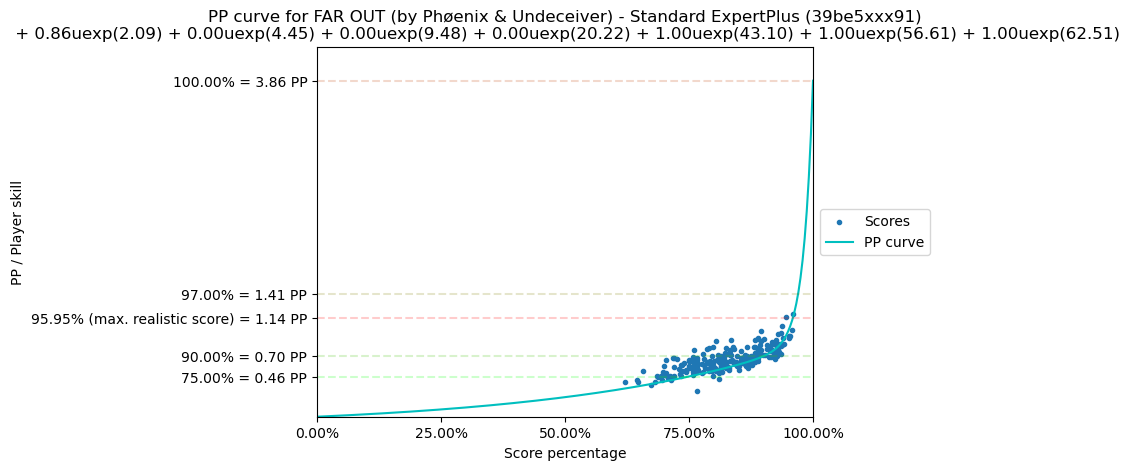

In [125]:
# Chart the PP curve of a map
example_map_id = "39be5xxx91"

show_map_pp_by_map_id(example_map_id)

# 1 - Global score stats

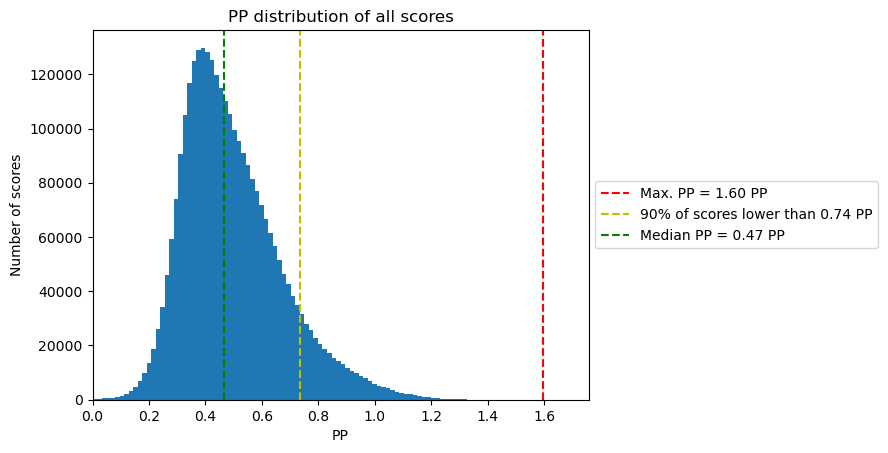

# 2 - Map PP statistics

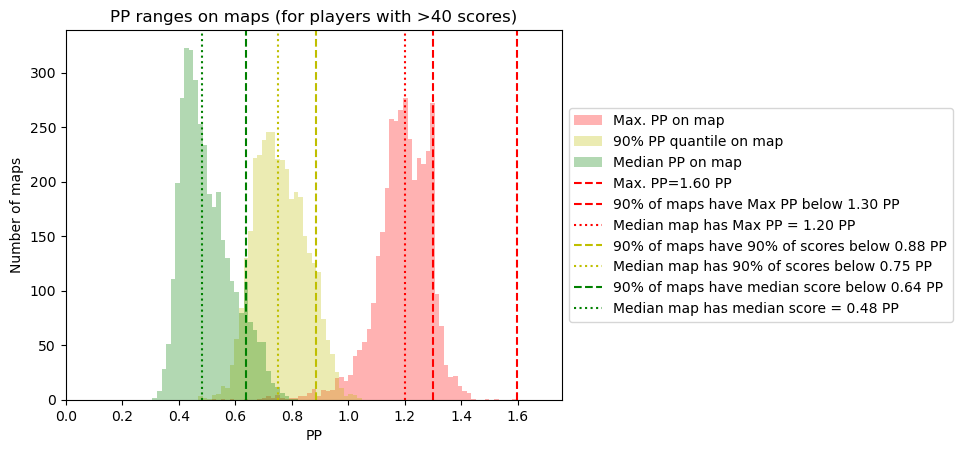

# 3 - PP compared with top PP from player, statistics per map (Concentration up and to the right is ideal)

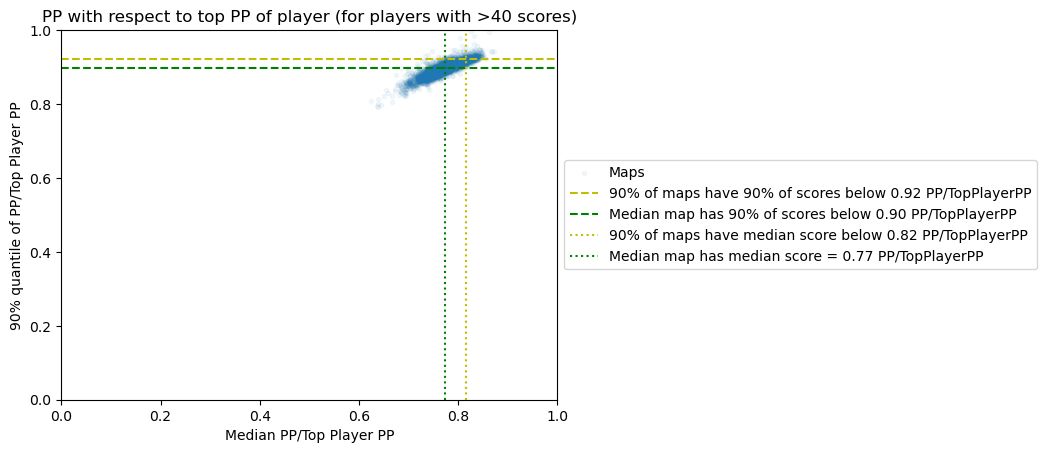

# 4 - PP compared with top PP from player, statistics per player (Concentration up and to the right is ideal)

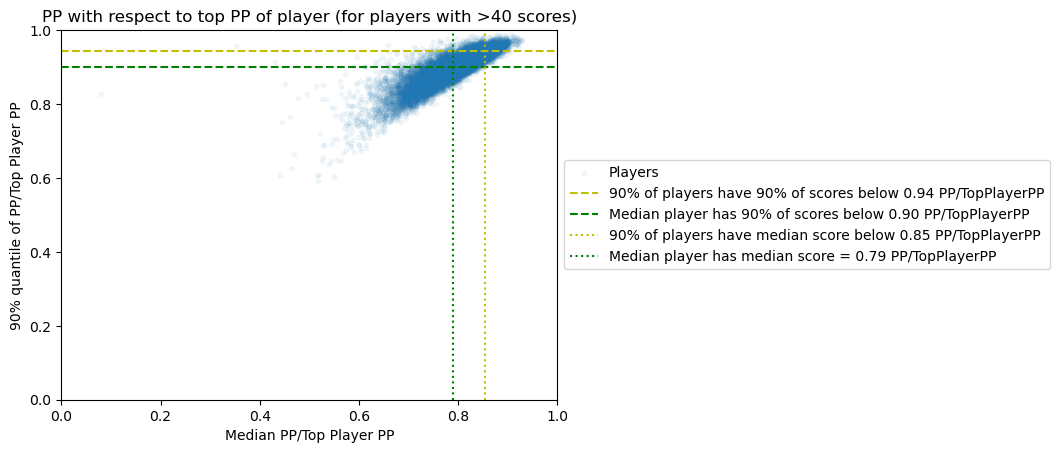

# 5 - PP compared with top PP from player, all scores (Concentration to the right is ideal)

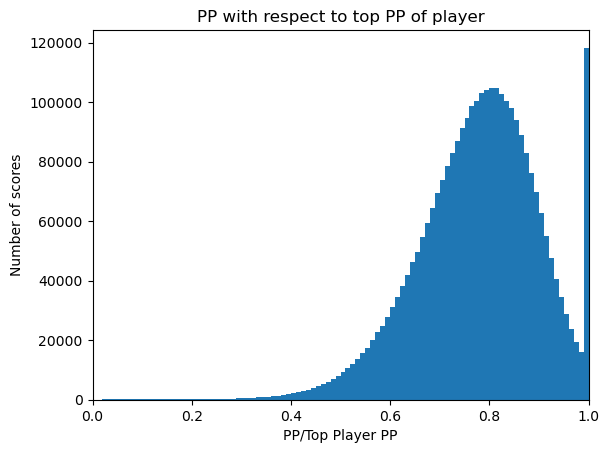

# 6 - PP compared with top PP from map, all scores (Good spread is ideal)

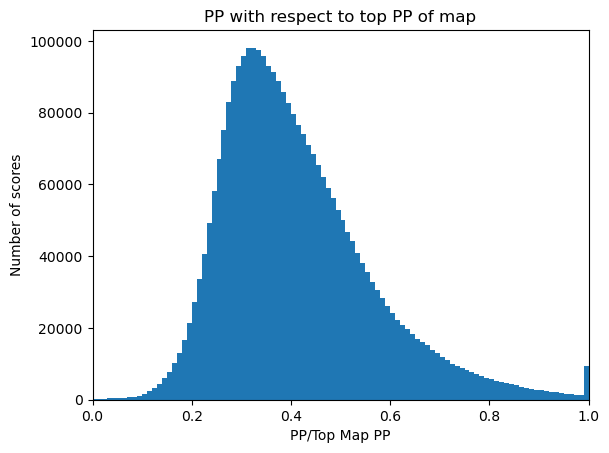

In [126]:
# General statistics of the dataset that matter for good PP balance
show_all_global_stats()